In [3]:
# Y. Zhang, July 2022
# Qiskit simulator for MBQC gates
import qiskit
#from MBQC_basic_functions import*
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit.quantum_info.operators import Operator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import Aer
from scipy.stats import unitary_group

import warnings #ignore Qiskit DeprecationWarnings - they're kinda annoying
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Purpose
CBQC and MBQC are known to be equivalent computation models. This notebook provides a tool to convert a (up to 3 qubit) qiskit CBQC circuit that is written in CBQC language into MBQC circuit.

In [76]:
def add_H(mcirc,qubit_index,active_qubit):
    indx = active_qubit[qubit_index[0]] # the position of the qubit in a MBQC register
    q = qubit_index[0] # the qubit labeling in the input circuit, not to be confused with the other index

    for i in range(4):
        #establish cluster state here
        mcirc.h(q*4 + (indx + 1)%2) # q*4 + indx is the absolute position of the qubit in the MBQC circ
        mcirc.cz(q*4 + indx, q*4 + (indx + 1)%2)
        # case by case measurements goes here
        if i ==0:
            mcirc.u2(0,np.pi,q*4 + indx)
        else:
            mcirc.u2(0,np.pi/2,q*4 + indx)#rotating into y-basis
        mcirc.measure(q*4 + indx, 14*q+i)
        mcirc.reset(q*4 + indx)
        indx = (indx + 1)%2
    #corrections
    for i in [1,2]:
        mcirc.z(q*4 + indx).c_if(14*q + i, 1)
    for i in [0,2,3]:
        mcirc.x(q*4 + indx).c_if(14*q + i, 1)
    active_qubit[qubit_index[0]] = indx
    return mcirc, active_qubit

def add_S(mcirc,qubit_index,active_qubit):
    indx = active_qubit[qubit_index[0]] # the position of the qubit in a MBQC register
    q = qubit_index[0] # the qubit labeling in the input circuit, not to be confused with the other index

    for i in range(4):
        #establish cluster state here
        mcirc.h(q*4 + (indx + 1)%2) # q*4 + indx is the absolute position of the qubit in the MBQC circ
        mcirc.cz(q*4 + indx, q*4 + (indx + 1)%2)
        # case by case measurements goes here
        if i in [0,1,3]:
            mcirc.u2(0,np.pi,q*4 + indx)
        else:
            mcirc.u2(0,np.pi/2,q*4 + indx)#rotating into y-basis
        mcirc.measure(q*4 + indx, 14*q+i)
        mcirc.reset(q*4 + indx)
        indx = (indx+1)%2
    #correction rules
    for i in [0,1,2]:
        mcirc.z(q*4 + indx).c_if(14*q + i, 1)
    for i in [1,3]:
        mcirc.x(q*4 + indx).c_if(14*q + i, 1)
    active_qubit[qubit_index[0]] = indx
    return mcirc, active_qubit

def add_RZ(mcirc,qubit_index,active_qubit,params):
    indx = active_qubit[qubit_index[0]] # the position of the qubit in a MBQC register
    q = qubit_index[0] # the qubit labeling in the input circuit, not to be confused with the other index

    for i in range(4):
        #establish cluster state here
        mcirc.h(q*4 + (indx + 1)%2) # q*4 + indx is the absolute position of the qubit in the MBQC circ
        mcirc.cz(q*4 + indx, q*4 + (indx + 1)%2)
        # case by case measurements goes here
        if i in [0,1,3]:
            mcirc.u2(0,np.pi,q*4 + indx)#rotating into x-basis
        elif i == 2:
            mcirc.unitary(Operator(arbitrary_measurement(-1*params[0])),q*4 + indx,label='unitary').c_if(14*q+1, 1)
            mcirc.unitary(Operator(arbitrary_measurement(params[0])),q*4 + indx,label='unitary').c_if(14*q+1, 0)

        mcirc.measure(q*4 + indx, 14*q+i)
        mcirc.reset(q*4 + indx)
        indx = (indx+1)%2
    #correction rules
    for i in [1,3]:
        mcirc.x(q*4 + indx).c_if(14*q + i, 1)
    for i in [0,2]:
        mcirc.z(q*4 + indx).c_if(14*q + i, 1)
    active_qubit[qubit_index[0]] = indx
    return mcirc, active_qubit

def add_U3_XZX(mcirc,qubit_index, active_qubit,params): # XZX is the convetion given in Robert's paper, in comparison to ZXZ
    indx = active_qubit[qubit_index[0]] # the position of the qubit in a MBQC register
    q = qubit_index[0] # the qubit labeling in the input circuit, not to be confused with the other index

    for i in range(3):
        #establish cluster state here
        mcirc.h(q*4 + (indx + 1)%2) # q*4 + indx is the absolute position of the qubit in the MBQC circ
        mcirc.cz(q*4 + indx, q*4 + (indx + 1)%2)
        # case by case measurements goes here
        if i ==0 :
            mcirc.u2(0,np.pi,q*4 + indx)#rotating into x-basis
        else:
            mcirc.unitary(Operator(arbitrary_measurement(-1*params[i-1])),q*4 + indx,label='unitary').c_if(14*q+i-1, 1)
            mcirc.unitary(Operator(arbitrary_measurement(params[i-1])),q*4 + indx,label='unitary').c_if(14*q+i-1, 0)
        mcirc.measure(q*4 + indx, 14*q+i)
        mcirc.reset(q*4 + indx)
        indx = (indx+1)%2
        
    #special case for i = 4 - need to use ancilla
    mcirc.h(q*4 + (indx + 1)%2) # q*4 + indx is the absolute position of the qubit in the MBQC circ
    mcirc.cz(q*4 + indx, q*4 + (indx + 1)%2)
    
    mcirc.x(q*4+2).c_if(14*q+0, 1)
    mcirc.x(q*4+2).c_if(14*q+2, 1)
    mcirc.measure(q*4+2,14*q+7)
    mcirc.reset(q*4+2)
    
    mcirc.unitary(Operator(arbitrary_measurement(-1*params[2])),q*4 + indx,label='unitary').c_if(14*q+7, 1)
    mcirc.unitary(Operator(arbitrary_measurement(params[2])),q*4 + indx,label='unitary').c_if(14*q+7, 0)
    mcirc.measure(q*4 + indx, 14*q+3)
    indx = (indx + 1)%2
    
    #correction rules
    for i in [1,3]:
        mcirc.x(q*4 + indx).c_if(14*q + i, 1)
    for i in [0,2]:
        mcirc.z(q*4 + indx).c_if(14*q + i, 1)
        
    active_qubit[qubit_index[0]] = indx
    return mcirc, active_qubit

def add_CX(mcirc, qubit_index, active_qubit): 
    indx0 = active_qubit[qubit_index[0]] # the position of the qubit in a MBQC register
    indx1 = active_qubit[qubit_index[1]]
    q0, q1 = qubit_index[0], qubit_index[1] # control, target
    
    for i in range (6):
        if i == 0:
            mcirc.h(q0*4 + (indx0 + 1)%2) # q*4 + indx is the absolute position of the qubit in the MBQC circ
            mcirc.cz(q0*4 + indx0, q0*4 + (indx0 + 1)%2)
            mcirc.u2(0,np.pi,q0*4 + indx0)#rotating into x-basis            
            mcirc.measure(q0*4 + indx0, 14*q0+i)
            mcirc.reset(q0*4 + indx0)
            indx0 = (indx0+1)%2
            
            mcirc.h(q1*4 + (indx1 + 1)%2) # q*4 + indx is the absolute position of the qubit in the MBQC circ
            mcirc.cz(q1*4 + indx1, q1*4 + (indx1 + 1)%2)
            mcirc.u2(0,np.pi,q1*4 + indx1)#rotating into x-basis 
            mcirc.measure(q1*4 + indx1, 14*q1+i)
            mcirc.reset(q1*4 + indx1)
            indx1 = (indx1+1)%2
            
        elif i in [1,2,4,5]:
            mcirc.h(q0*4 + (indx0 + 1)%2) # q*4 + indx is the absolute position of the qubit in the MBQC circ
            mcirc.cz(q0*4 + indx0, q0*4 + (indx0 + 1)%2)
            mcirc.u2(0,np.pi/2,q0*4 + indx0)#rotating into y-basis            
            mcirc.measure(q0*4 + indx0, 14*q0+i)
            mcirc.reset(q0*4 + indx0)
            indx0 = (indx0+1)%2
            
            mcirc.h(q1*4 + (indx1 + 1)%2) # q*4 + indx is the absolute position of the qubit in the MBQC circ
            mcirc.cz(q1*4 + indx1, q1*4 + (indx1 + 1)%2)
            mcirc.u2(0,np.pi,q1*4 + indx1)#rotating into x-basis 
            mcirc.measure(q1*4 + indx1, 14*q1+i)
            mcirc.reset(q1*4 + indx1)
            indx1 = (indx1+1)%2
            
        else: #this part would be situational; if we extend the circuit size we would have 

            if q0 + q1 ==2:
                q_anc = 5 
            else: 
                q_anc = (min(q0,q1) + 1)

            #build cluster state
            mcirc.h(q0*4 + (indx0 + 1)%2) # q*4 + indx is the absolute position of the qubit in the MBQC circ
            mcirc.h(q1*4 + (indx1 + 1)%2)
            mcirc.h(2*q_anc)
            
            mcirc.cz(q1*4 + indx0, 2*q_anc)
            mcirc.cz(q0*4 + indx1, 2*q_anc)
            
            mcirc.cz(q0*4 + indx0, q0*4 + (indx0 + 1)%2)
            mcirc.cz(q1*4 + indx1, q1*4 + (indx1 + 1)%2)

            
            mcirc.u2(0,np.pi/2,q0*4 + indx0)#rotating into y-basis            
            mcirc.u2(0,np.pi/2,q1*4 + indx1)#rotating into y-basis 
            mcirc.u2(0,np.pi/2,2*q_anc)#rotating into y-basis 

            mcirc.measure(q0*4 + indx0, 14*q0+i)
            mcirc.reset(q0*4 + indx0)
            indx0 = (indx0+1)%2
            
            mcirc.measure(q1*4 + indx1, 14*q1+i)
            mcirc.reset(q1*4 + indx1)
            indx1 = (indx1+1)%2
            
            mcirc.measure(2*q_anc, 7*q_anc)
            mcirc.reset(2*q_anc)
    
    # correction rules
    # x correction on control bit
    for i in [1,2,4,5]:
        mcirc.x(q0*4 + indx0).c_if(14*q0 + i, 1)
        
    # x correction on target bit
    for i in [1,2]:
        mcirc.x(q1*4 + indx1).c_if(14*q0 + i, 1)
        
    for i in [1,3,5]:
        mcirc.x(q1*4 + indx1).c_if(14*q1 + i, 1)
    
    mcirc.x(q1*4 + indx1).c_if(7*q_anc, 1)
    
    # z correction on control bit
    for i in [0,2,3,4]:
        mcirc.z(q0*4 + indx0).c_if(14*q0 + i, 1)
        
    for i in [0,2,]:
        mcirc.z(q0*4 + indx0).c_if(14*q1 + i, 1)
    mcirc.z(q0*4 + indx0).c_if(7*q_anc, 1)
    mcirc.z(q0*4 + indx0)
    
    # z correction on target bit   
    for i in [0,2,4]:
        mcirc.z(q1*4 + indx1).c_if(14*q1+ i, 1)

    active_qubit[qubit_index[0]] = indx0
    active_qubit[qubit_index[1]] = indx1
    return mcirc, active_qubit

## Example: GHZ state
We first define a circuit to prepare GHZ state 
$$ |\psi_{GHZ} \rangle = \frac{1}{\sqrt{2}}(|000\rangle +|111\rangle).$$


In [3]:
#The circuit without measurement
circ = QuantumCircuit(3,3)

circ.h(0)
circ.cx(0,1)
circ.cx(0,2)

circ.measure(0,0)
circ.measure(1,1)
circ.measure(2,2)
simulator = Aer.get_backend('aer_simulator')
result = simulator.run(circ,shot= 1000).result()
counts = result.get_counts(circ)
counts

{'111': 512, '000': 512}

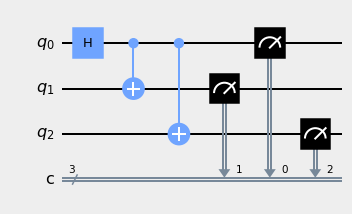

In [4]:
#it looks like this
circ.draw(output='mpl', style={'backgroundcolor': '#EEEEEE'})

The measurement results clearly shows that we've prepared a GHZ state

Now, take a look at the way Qiskit stores all gate information:

In [5]:
circ.data

[(Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'q'), 0)], []), (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)], []), (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 2)], []), (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(3, 'q'), 0)], [Clbit(ClassicalRegister(3, 'c'), 0)]), (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(3, 'q'), 1)], [Clbit(ClassicalRegister(3, 'c'), 1)]), (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(3, 'q'), 2)], [Clbit(ClassicalRegister(3, 'c'), 2)])]

In [75]:

def conversion(circ):
    mcirc = QuantumCircuit()
    qubits = circ.qubits # list of all qubits
    active_qubit = [0]*(2*len(qubits)) # which qubit quantum state stores information?
    
    for i in range(2*len(qubits)):
        #setting the stage
        if i%2 ==0:
            qreg = QuantumRegister(2,f'q_comp{i//2}') # need to keep 2 qubits for the simulation
            creg = ClassicalRegister(7,f'cl_comp{i//2}')# classical registers are set to record information
            mcirc.add_register(qreg,creg)
        else: #ancilla registers
            qreg = QuantumRegister(2,f'q_anc{i//2}') 
            creg = ClassicalRegister(7,f'cl_anc{i//2}')
            mcirc.add_register(qreg,creg)
            
    for gate in circ.data:
        gate_name = gate[0].name
        qubit_name = gate[1]
        params = gate[0].params
        qubit_index = [qubits.index(qubit) for qubit in qubit_name]
        if gate_name == 'h':
            mcirc, active_qubit = add_H(mcirc,qubit_index, active_qubit)
        elif gate_name == 's':
            mcirc, active_qubit = add_S(mcirc,qubit_index, active_qubit)
        elif gate_name == 'rz':
            mcirc, active_qubit = add_RZ(mcirc,qubit_index, active_qubit, params)
        elif gate_name == 'u3' or gate_name == 'u':
            param = [params[2]-np.pi/2, params[0], params[1]+np.pi/2]
            mcirc.h(qubit_index[0]*4 + active_qubit[qubit_index[0]])
            mcirc, active_qubit = add_U3_XZX(mcirc,qubit_index, active_qubit, param)
            mcirc.h(qubit_index[0]*4 + active_qubit[qubit_index[0]])
        elif gate_name == 'cx':
            mcirc, active_qubit = add_CX(mcirc,qubit_index,active_qubit)
        elif gate_name == 'measure':
            i = qubit_index[0]
            mcirc.measure(4*i+active_qubit[2*i],-1*i-1)            
        else: print('Unsupported gate class')
    return mcirc, active_qubit

mcirc, active_qubit = conversion(circ)



NameError: name 'circ' is not defined

In [68]:
from scipy.stats import unitary_group
# write a function to do the noisy CNOT sim 
def benchmarking_CX(shots, p = 0):
    rand_u = unitary_group.rvs(4)
    rand_u_inv = np.conj(rand_u.T)
    nm = get_noise(p)
    mcirc = QuantumCircuit()
    active_qubit = [0]*(2*2) # which qubit quantum state stores information?
    
    for i in range(2*2):
        #setting the stage
        if i%2 ==0:
            qreg = QuantumRegister(2,f'q_comp{i//2}') # need to keep 2 qubits for the simulation
            creg = ClassicalRegister(7,f'cl_comp{i//2}')# classical registers are set to record information
            mcirc.add_register(qreg,creg)
        else: #ancilla registers
            qreg = QuantumRegister(2,f'q_anc{i//2}') 
            creg = ClassicalRegister(7,f'cl_anc{i//2}')
            mcirc.add_register(qreg,creg)
        
    mcirc.unitary(rand_u, [0, 4], label='rand_u')
    mcirc, active_qubit = add_CX(mcirc,[0,1],active_qubit)
    mcirc.cx(0,4)
    mcirc.unitary(rand_u_inv, [0, 4], label='rand_u_inv') 
    for i in range(2):
        mcirc.measure(4*i+active_qubit[2*i],-1*i-1)
        
    simulator = Aer.get_backend('aer_simulator')    
    job = simulator.run(mcirc)
    result = simulator.run(mcirc, noise_model = nm, shots= shots).result()
    counts = result.get_counts(mcirc)

    n = only_useful_counts(counts, active_qubit)['00']
    return n/shots


In [77]:
plist = np.arange(1,10,1)*0.02
fids = []
var = []
for p in plist:
    fid = []
    for k in range (100):
        fid.append(benchmarking_CX(100,p))
    fids.append(np.average(fid))
    var.append(np.var(fid))
    

In [79]:
fids

[0.7306,
 0.5722,
 0.45260000000000006,
 0.3858,
 0.33599999999999997,
 0.3024,
 0.28740000000000004,
 0.27449999999999997,
 0.261]

In [17]:
def get_noise(p):
    p2 = p/15 
    p1 = p
    error_meas = pauli_error([('X',p1/3),('Z',p1/3),('Y',p1/3), ('I', 1 - p1)]) #isotropic error model
    error_cz = pauli_error([('IX',p2),('IZ',p2),('IY',p2),('XI',p2),('ZI',p2),('YI',p2), ('XX',p2),('XY',p2),('XZ',p2),('YX',p2),('YY',p2),('YZ',p2),('ZX',p2),('ZY',p2),('ZZ',p2),('II', 1 - p)]) #isotropic error model

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas,'unitary') # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_meas,'u2')
    noise_model.add_all_qubit_quantum_error(error_cz,'cz') 

    return noise_model
only_useful_counts(counts, active_qubit)

{'10': 213, '11': 255, '00': 323, '01': 233}

In [59]:
simulator = Aer.get_backend('aer_simulator')

# Create a Quantum Program for execution

result = simulator.run(mcirc,shots= 100).result()
counts = result.get_counts(mcirc)


In [61]:
len(counts)

958

### Getting rid of the uncecessary counts

In [30]:
#get rid of the ancilla registers...
def only_useful_counts(counts, active_qubit): 
    useful_string_len = len(active_qubit)//2 #devided by 2 b/c we have an ancilla register per computation qubit
    old_keys = list(counts.keys())
    new_counts = {}

    for i in range (len(list(counts.keys()))):
        new_key = old_keys[i][:useful_string_len]
        if new_key not in new_counts.keys():
            new_counts[new_key] = counts[old_keys[i]]
        else: 
            new_counts[new_key] += counts[old_keys[i]]
    return new_counts
only_useful_counts(counts, active_qubit)

{'10': 213, '11': 255, '00': 323, '01': 233}

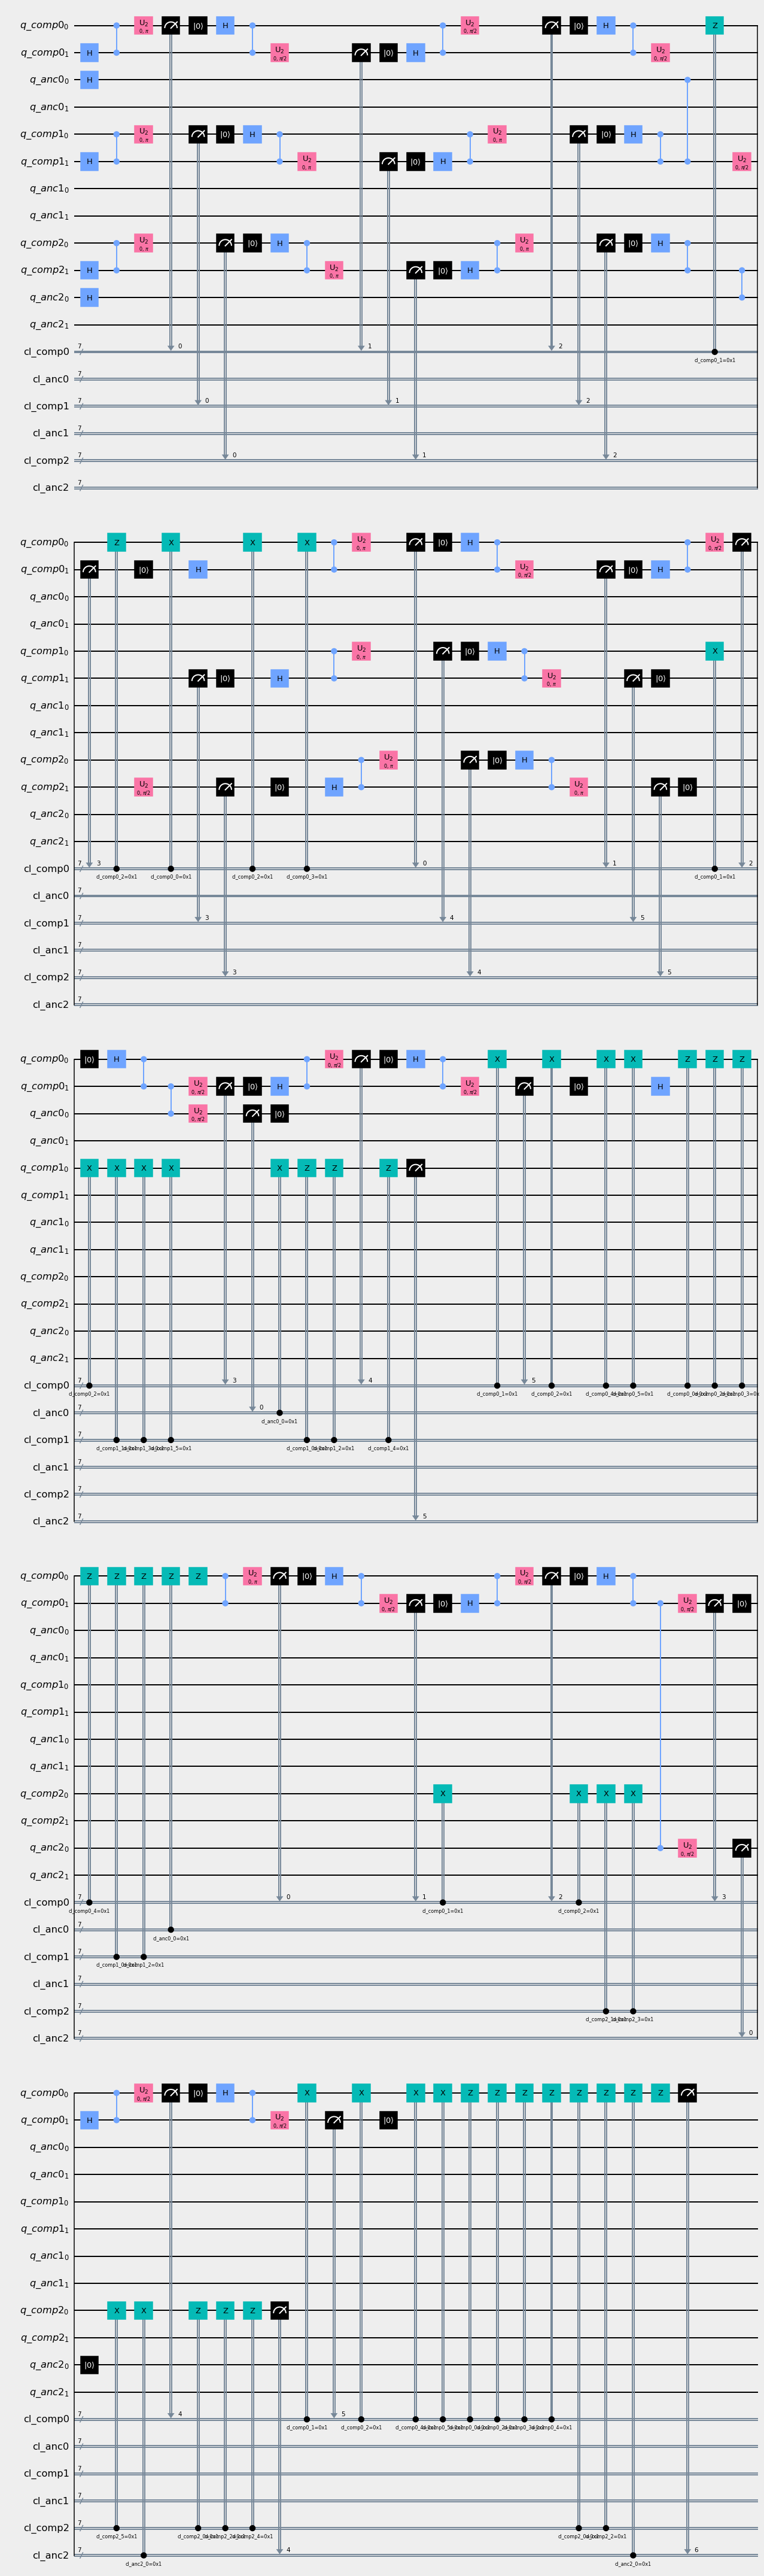

In [10]:
mcirc.draw(output='mpl', style={'backgroundcolor': '#EEEEEE'})

## QV simulation
The following work is based on IBM's tutorial

https://qiskit.org/textbook/ch-quantum-hardware/measuring-quantum-volume.html

First, we generate QV circuits

In [14]:
import qiskit.ignis.verification.quantum_volume as qv
from IPython.display import clear_output

#Import Qiskit classes
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error


# qubit_lists: list of list of qubit subsets to generate QV circuits
qubit_lists = [[0,1,3],]
# ntrials: Number of random circuits to create for each subset
ntrials = 200
qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

# pass the first trial of the nomeas through the transpiler to illustrate the circuit
qv_circs_nomeas[0] = qiskit.compiler.transpile(qv_circs_nomeas[0], basis_gates=['u3','cx'])

qv_circs_nomeas[0][0].draw(fold=-1)


global phase: 5.2853
     ┌────────────────────────────┐                                                                                                                 ┌──────────────────────┐           ┌─────────────────────┐        ┌──────────────────────────────┐                                                                                                         
q_0: ┤ U3(0.1271,-3.0459,-1.3815) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────■─────┤ U3(0.8555,-π/2,-π/2) ├─────■─────┤ U3(0.013323,0,-π/2) ├─────■──┤ U3(0.30137,-3.0986,-0.78511) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────
     ├────────────────────────────┤┌───┐┌─────────────────────────────┐┌───┐┌───────────────────────────┐┌───┐┌────────────────────────────┐  │     └──────────────────────┘     │     └─────────────────────┘     │  └──────────────────────────────┘┌───┐┌─────────────────────────────┐┌───┐┌───────────────────────────┐┌───┐┌───────────────────────────┐ 
q_1: ┤ U3(0.50331,0.67387,1.2515) ├┤ X ├┤ U3(1.9806,-2.4511,-0.44942) ├┤ X ├┤ U3(2π/3,0.61548,-0.61548) ├┤ X ├┤ U3(2.0293,-1.9864,0.95712) ├──┼──────────────────────────────────┼─────────────────────────────────┼──────────────────────────────────┤ X ├┤ U3(1.9477,-2.4349,-0.40699) ├┤ X ├┤ U3(2π/3,0.61548,-0.61548) ├┤ X ├┤ U3(1.6804,2.8843,0.86587) ├─
     └┬──────────────────────────┬┘└─┬─┘└──┬───────────────────────┬──┘└─┬─┘└───┬────────────────────┬──┘└─┬─┘├───────────────────────────┬┘┌─┴─┐┌────────────────────────────┐┌─┴─┐┌───────────────────────────┐┌─┴─┐ ┌────────────────────────────┐ └─┬─┘└──┬───────────────────────┬──┘└─┬─┘└───┬────────────────────┬──┘└─┬─┘├───────────────────────────┴┐
q_2: ─┤ U3(2.2466,2.1078,-3.118) ├───■─────┤ U3(0.55001,-π/2,-π/2) ├─────■──────┤ U3(0.33858,-π,π/2) ├─────■──┤ U3(2.864,-1.5778,-1.2225) ├─┤ X ├┤ U3(1.896,-2.4132,-0.34391) ├┤ X ├┤ U3(2π/3,0.61548,-0.61548) ├┤ X ├─┤ U3(0.33138,1.0077,-2.6447) ├───■─────┤ U3(0.94794,-π/2,-π/2) ├─────■──────┤ U3(0.88943,-π,π/2) ├─────■──┤ U3(1.7301,-0.30383,2.3379) ├
      └──────────────────────────┘         └───────────────────────┘            └────────────────────┘        └───────────────────────────┘ └───┘└────────────────────────────┘└───┘└───────────────────────────┘└───┘ └────────────────────────────┘         └───────────────────────┘            └────────────────────┘        └────────────────────────────┘

In [15]:
# if one wants to add in more depth, change the following function:
# https://qiskit.org/documentation/stable/0.28/_modules/qiskit/ignis/verification/quantum_volume/circuits.html

sv_sim = qiskit.Aer.get_backend('aer_simulator')
ideal_results = []
for trial in range(ntrials):
    clear_output(wait=True)
    for qc in qv_circs_nomeas[trial]:
        qc.save_statevector()
    result = qiskit.execute(qv_circs_nomeas[trial], backend=sv_sim).result()
    ideal_results.append(result)
    print(f'Simulated trial {trial+1}/{ntrials}')
    
qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

for qubit_list in qubit_lists:
    l = len(qubit_list)
    print ('qv_depth_'+str(l)+'_trial_0:', qv_fitter._heavy_outputs['qv_depth_'+str(l)+'_trial_0'])

Simulated trial 200/200
qv_depth_3_trial_0: ['000', '001', '100', '110']


In [19]:
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(1-error_rules(p_meas, 'H', theta = 0),1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(1-error_rules(p_meas, 'H', theta = 0),1), 'u3')
noise_model.add_all_qubit_quantum_error(pauli_error(CNOT_error(p_meas*6)), 'cx')

[0, 1, 3]